## Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
FOLDER_PATH = 'Colab Notebooks/Pedro-Londono_CW_Folder/'

MODELS_PATH = 'Colab Notebooks/Pedro-Londono_CW_Folder/Models'

GOOGLE_FOLDER_PATH = os.path.join('drive', 'My Drive', FOLDER_PATH)
GOOGLE_MODELS_PATH = os.path.join('drive', 'My Drive', MODELS_PATH)
 
print(os.listdir(GOOGLE_MODELS_PATH))
print(os.listdir(GOOGLE_FOLDER_PATH))


['MLP.ipynb', 'CNN.ipynb', 'SVM_Model.py', '__pycache__', 'HOG-BoW-SVM.ipynb', 'SVC_Alone.ipynb', 'HOG-SVM.ipynb', 'SIFT-BoW-SVM.ipynb', 'HOG-MLP.ipynb']
['Models', 'CW_Dataset', 'svc_alone.joblib', 'svc_hog.joblib', 'variables', 'assets', 'mlp_arc1.h5', 'mlp_arc2.h5', 'knn.joblib', 'svc_sift.joblib', 'cnn_arc1.h5', 'test_function.ipynb', 'kmeans.joblib', 'hog_mlp_arc1.h5']


## Reading the dataset

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
CODE_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'Code')
sys.path.append(CODE_PATH)


In [ ]:
!pip install opencv-python==4.4.0.46


     |████████████████████████████████| 49.5MB 82kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import cv2
from skimage import img_as_ubyte, io, color
import numpy as np
import matplotlib.pyplot as plt

DATASET_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'CW_Dataset')

def load_images_from_folder(path, label_list=None):
  images = []
  labels = []
  img_labels = {}
  if label_list is None:
    folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('README')]
    print('folder_names', folder_names)
  else:
    folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list.endswith('.jpg')]  
  
  for folder in folder_names:
    file_names = [file for file in sorted(os.listdir(os.path.join(path, folder)))]
    print('file_names', file_names)
    for file in file_names:

      if file.endswith('.txt'):
        labels_rd = np.loadtxt(os.path.join(path, folder, file), delimiter=' ', usecols=(1)).tolist()

        [labels.append(label) for label in labels_rd]
        print(labels[:5], len(labels))
        
        print(folder, file, labels)
      else:
        rep_str = '(1)'
        if rep_str not in file:
          images.append(io.imread(os.path.join(path, folder, file)))
        print(folder, file)
  return images, labels



X, y = load_images_from_folder(DATASET_PATH)



Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07288_aligned.jpg
train train_07289_aligned.jpg
train train_07290_aligned.jpg
train train_07291_aligned.jpg
train train_07292_aligned.jpg
train train_07293_aligned.jpg
train train_07294_aligned.jpg
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train

## Introduction

The RAF dataset contains 15339 aligned facial color images containing expressions and labels for the images, the labels are encoded using ordinal encoding for every emotion. 

### Data
Images are named in the format of "train_XXXXX_aligned.jpg" / "test_XXXX_aligned.jpg".
Images are first roughly aligned using similarity transformation according to the two eye locations and the center of mouth.

Images are then resized to 100*100

#### Label explanation:
1. Surprise<p>
2. Fear<p>
3. Disgust<p>
4. Happiness<p>
5. Sadness
6. Anger
7. Neutral





## Data Preprocessing

Data was preprocessed by converting it to grayscale, at first using colors channels was used, however it was taking to long to train some models such as the SVM model. Using colors the main problem was the curse of dimentionality, even trying to use much less columns. Based on the dataset using color would not give much insight, as to recornise emotions, color probably has less importance. Thus, converting to grayscale reduced the training time. 




(15339, 100, 100, 3) (15339,)


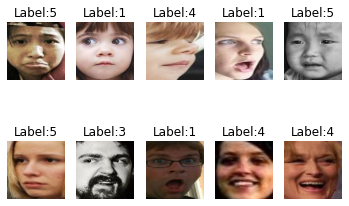

In [ ]:
#from sklearn.preprocessing import

def convert_to_numpy(images, labels):
  """Converts the images to a numpy array""" 
  
  data = np.asarray(images)
  lb = np.asarray(labels)
  return data, lb

X, y = convert_to_numpy(X, y)


X = X / 255.
X = X.astype(np.float32)
y = y.astype(np.int32)

print(X.shape, y.shape)


#def print_images()
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
ax = axs.ravel()
for i in range(10):
  ax[i].imshow(X[i, :, :, :])
  ax[i].set_title(f'Label:{y[i]}')
  ax[i].set_axis_off()
plt.show()



In [ ]:
from skimage import img_as_ubyte, color
from skimage.transform import rescale, resize


#image_resized = resize(image, (image.shape[0] / 4, image.shape[1] / 4),
#                       anti_aliasing=True)
#X = X.reshape(-1, 100*100*3)


X = img_as_ubyte(color.rgb2gray(X))
X = X.reshape(-1, 100*100)
X.shape



(15339, 10000)

In [ ]:
print(X.dtype, y.dtype)
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]


uint8 int32
TRAIN: [ 2191  2206  2217 ... 15336 15337 15338] TEST: [   0    1    2 ... 3484 3511 3514]
TRAIN: [    0     1     2 ... 15336 15337 15338] TEST: [ 2191  2206  2217 ... 13414 13415 13416]
TRAIN: [    0     1     2 ... 15336 15337 15338] TEST: [ 5171  5172  5173 ... 14055 14056 14057]
TRAIN: [    0     1     2 ... 15336 15337 15338] TEST: [ 6762  6763  6767 ... 14696 14697 14698]
TRAIN: [    0     1     2 ... 14696 14697 14698] TEST: [ 9498  9499  9500 ... 15336 15337 15338]


In [ ]:
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.optimizers import SGD, Nadam, Adam, RMSprop, Adagrad, Adadelta, Adamax
from keras.optimizers import RMSprop
from keras import datasets
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import expon
from sklearn.utils.fixes import loguniform
from scipy.stats import randint, loguniform, poisson, boltzmann
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from keras.utils.np_utils import to_categorical
classes = np.unique(y_train) 
classes


array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=8)
#Y_test = to_categorical(y_test, num_classes=8)

print(y_train.shape)

(12272, 8)


### Arquitecture 1

In [ ]:
from keras.utils.np_utils import to_categorical
#y_train = to_categorical(classes, num_classes=classes.shape[0])
metrics = [tf.keras.metrics.CategoricalAccuracy() ,tf.keras.metrics.AUC(3), tf.keras.metrics.Precision()]
model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(80, activation='selu',))
model.add(Dense(100, activation='elu', kernel_initializer='glorot_normal'))
model.add(Dense(80, activation='sigmoid'))
model.add(Dense(20, activation='softplus', kernel_initializer='glorot_normal'))
model.add(Dense(8, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.0003), metrics=metrics)

model.fit(X_train, y_train, epochs=500, batch_size=86)

model.summary()


Epoch 1/500
143/143 [==============================] - 2s 9ms/step - loss: 2.1889 - categorical_accuracy: 0.1305 - auc: 0.4998 - precision: 0.0000e+00
Epoch 2/500
143/143 [==============================] - 1s 9ms/step - loss: 1.8357 - categorical_accuracy: 0.3856 - auc: 0.5000 - precision: 0.0000e+00
Epoch 3/500
143/143 [==============================] - 1s 9ms/step - loss: 1.7576 - categorical_accuracy: 0.3887 - auc: 0.5000 - precision: 0.0000e+00
Epoch 4/500
143/143 [==============================] - 1s 9ms/step - loss: 1.6994 - categorical_accuracy: 0.3959 - auc: 0.5000 - precision: 0.0000e+00
Epoch 5/500
143/143 [==============================] - 1s 9ms/step - loss: 1.6696 - categorical_accuracy: 0.4015 - auc: 0.5204 - precision: 0.7712
Epoch 6/500
143/143 [==============================] - 1s 9ms/step - loss: 1.5810 - categorical_accuracy: 0.4593 - auc: 0.5840 - precision: 0.7508
Epoch 7/500
143/143 [==============================] - 1s 9ms/step - loss: 1.5586 - categorical_accura

In [ ]:
model.save(GOOGLE_FOLDER_PATH + 'mlp_arc1.h5')

In [ ]:
y_test = to_categorical(y_test, num_classes=8)
print(y_test.shape)

y_pred = model.predict(X_test)
y_pred[0, :]

(3067, 8)


array([4.0733257e-06, 1.7132432e-03, 1.8357519e-04, 7.4344696e-03,
       3.5659990e-03, 2.2042347e-02, 6.9133507e-04, 9.6436501e-01],
      dtype=float32)

In [ ]:
y_test = [np.argmax(y) for y in y_test[:, :]]

y_pred = [np.argmax(y_p) for y_p in y_pred[:, :]]

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
probas = model.predict_proba(X_test)

#precision_recall_curve(y_test, [np.argmax(prob) for prob in probas[:, :]])
precision_score = precision_score(y_test, y_pred, average='weighted')
accuracy_score = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average='weighted')
recall_score = recall_score(y_test, y_pred, average='weighted')
print(f'precision score: {precision_score}')
print(f'accuracy score: {accuracy_score}')
print(f'f1 score: {f1_score}')
print(f'recall score: {recall_score}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


precision score: 0.6272206537095671
accuracy score: 0.6247147049233779
f1 score: 0.6191620729006613
recall score: 0.6247147049233779


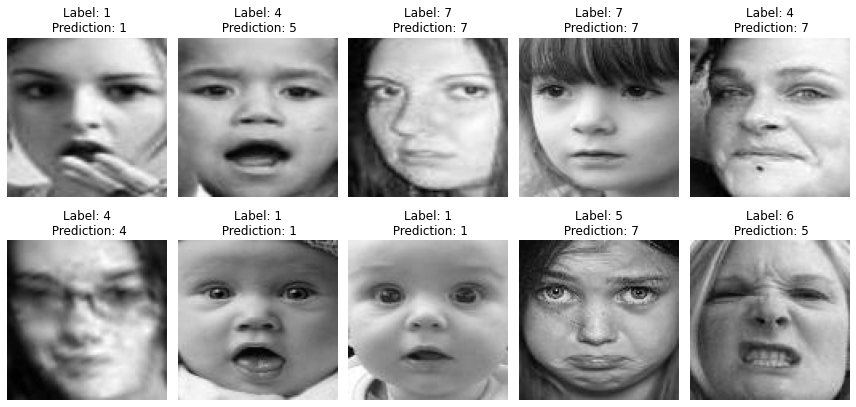

In [ ]:
from sklearn.utils import shuffle
X_test, y_test, y_pred = shuffle(X_test,  y_test, y_pred)
X_test_img = X_test.reshape(-1, 100, 100)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

[[216   0   4  23  14   8  58]
 [ 20  16   1  12   7   8   7]
 [  9   0  31  31  27  10  67]
 [ 30   5  16 929  76  11 125]
 [ 22   0  19  61 229   9 152]
 [ 15   4  19  25  19  69  23]
 [ 39   0  15  62  89   9 426]]


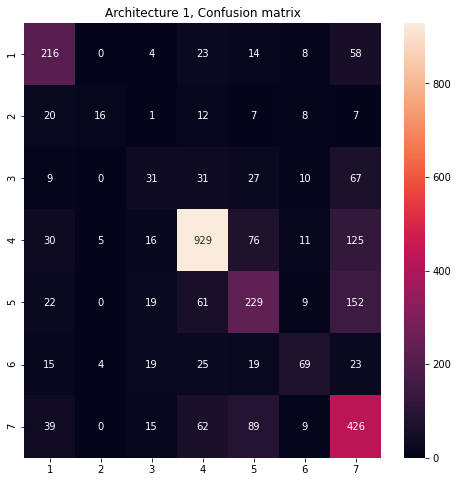

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in "1234567"],
                  columns = [i for i in "1234567"])

fig, ax = plt.subplots(figsize=(8, 8))

plt.title(f'Architecture 1, Confusion matrix')

sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

### Architecture 2

In [ ]:


metrics = [tf.keras.metrics.CategoricalAccuracy() ,tf.keras.metrics.AUC(3), tf.keras.metrics.Precision()]

model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='softplus'))
model.add(Dense(60, activation='relu'))
model.add(Dense(80, activation='selu')) #relu
model.add(Dense(100, activation='elu', kernel_initializer='glorot_normal')) #softplus elu, relu, relu
model.add(Dense(80, activation='sigmoid')) #sigmoid
model.add(Dense(20, activation='softplus', kernel_initializer='glorot_normal'))
model.add(Dense(8, activation='softmax'))

 
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.0003), metrics=metrics)
#learning_rate=0.001, momentum=0.0003
model.fit(X_train, y_train, epochs=500, batch_size=86)

model.summary()


Epoch 1/500
143/143 [==============================] - 2s 9ms/step - loss: 1.8516 - categorical_accuracy: 0.3242 - auc_1: 0.5000 - precision_1: 0.0000e+00
Epoch 2/500
143/143 [==============================] - 1s 9ms/step - loss: 1.6648 - categorical_accuracy: 0.4249 - auc_1: 0.5013 - precision_1: 0.3601
Epoch 3/500
143/143 [==============================] - 1s 9ms/step - loss: 1.6150 - categorical_accuracy: 0.4367 - auc_1: 0.5710 - precision_1: 0.7226
Epoch 4/500
143/143 [==============================] - 1s 9ms/step - loss: 1.5411 - categorical_accuracy: 0.4653 - auc_1: 0.6081 - precision_1: 0.7515
Epoch 5/500
143/143 [==============================] - 1s 9ms/step - loss: 1.5128 - categorical_accuracy: 0.4639 - auc_1: 0.6148 - precision_1: 0.7408
Epoch 6/500
143/143 [==============================] - 1s 9ms/step - loss: 1.4899 - categorical_accuracy: 0.4649 - auc_1: 0.6176 - precision_1: 0.7269
Epoch 7/500
143/143 [==============================] - 1s 9ms/step - loss: 1.4452 - catego

In [ ]:
from joblib import dump, load

model.save(GOOGLE_FOLDER_PATH + 'mlp_arc2.h5')



In [ ]:
y_test = to_categorical(y_test, num_classes=8)
print(y_test.shape)

y_pred = model.predict(X_test)
y_pred[0, :]

(3067, 8)


array([2.3675815e-05, 8.6088544e-01, 3.6634501e-02, 1.9443739e-03,
       4.5548953e-04, 8.3843037e-02, 2.5010402e-03, 1.3712512e-02],
      dtype=float32)

In [ ]:
y_test = [np.argmax(y) for y in y_test[:, :]]
#y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
y_pred = [np.argmax(y_p) for y_p in y_pred[:, :]]


In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
probas = model.predict(X_test)

#precision_recall_curve(y_test, [np.argmax(prob) for prob in probas[:, :]])
precision_score = precision_score(y_test, y_pred, average='weighted')
accuracy_score = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average='weighted')
recall_score = recall_score(y_test, y_pred, average='weighted')
print(f'precision score: {precision_score}')
print(f'accuracy score: {accuracy_score}')
print(f'f1 score: {f1_score}')
print(f'recall score: {recall_score}')

precision score: 0.615764551174556
accuracy score: 0.6243886534072384
f1 score: 0.610857547754856
recall score: 0.6243886534072384


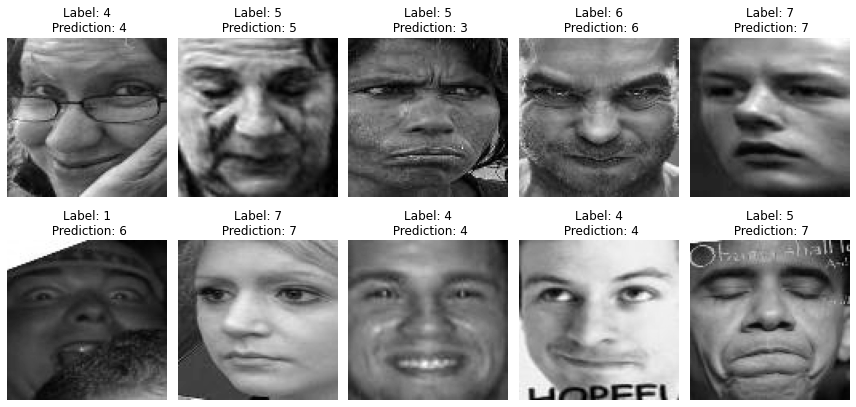

In [ ]:
from sklearn.utils import shuffle
X_test, y_test, y_pred = shuffle(X_test,  y_test, y_pred)
X_test_img = X_test.reshape(-1, 100, 100)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

[[229   2   2  18   8  12  52]
 [ 14  20   1  13   7  11   5]
 [  9   1  38  43   9  22  53]
 [ 36   6  16 982  35  23  94]
 [ 32   2  22 107 164  13 152]
 [ 16   5  13  31   9  80  20]
 [ 38   2  22 107  48  21 402]]


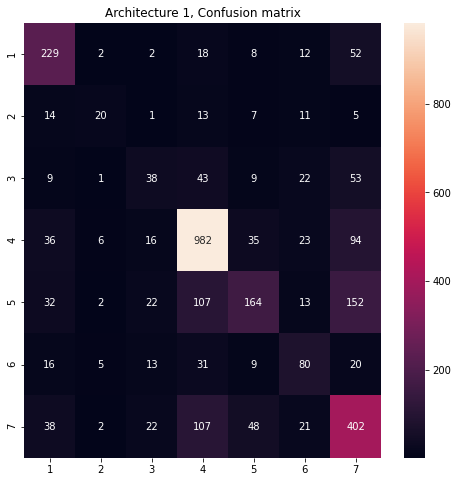

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in "1234567"],
                  columns = [i for i in "1234567"])

fig, ax = plt.subplots(figsize=(8, 8))

plt.title(f'Architecture 2, Confusion matrix')

sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

### Other Architectures Tried

In [ ]:
from keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(80, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(20, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.0003), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=400, batch_size=86)

model.summary()

Epoch 1/400
143/143 [==============================] - 5s 29ms/step - loss: 1.7667 - accuracy: 0.2577
Epoch 2/400
143/143 [==============================] - 4s 29ms/step - loss: 1.7049 - accuracy: 0.3855
Epoch 3/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6856 - accuracy: 0.3807
Epoch 4/400
143/143 [==============================] - 4s 28ms/step - loss: 1.6418 - accuracy: 0.3943
Epoch 5/400
143/143 [==============================] - 4s 28ms/step - loss: 1.6446 - accuracy: 0.3882
Epoch 6/400
143/143 [==============================] - 4s 28ms/step - loss: 1.6229 - accuracy: 0.3920
Epoch 7/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6256 - accuracy: 0.3913
Epoch 8/400
143/143 [==============================] - 4s 28ms/step - loss: 1.6175 - accuracy: 0.3844
Epoch 9/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6085 - accuracy: 0.3883
Epoch 10/400
143/143 [==============================] - 4s 29ms/step - loss: 1.602

In [ ]:
from keras.utils.np_utils import to_categorical
#y_train = to_categorical(classes, num_classes=classes.shape[0])

#y_train = to_categorical(y_train)
#print(y_train.shape)
#y_test = to_categorical(y_test)
model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(60, activation='relu'))
model.add(Dense(80, activation='tanh'))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(20, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.0003), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=86)


In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(40, activation='relu'))
#model.add(Dense(60, activation='sigmoid'))
model.add(Dense(60, activation='relu'))
model.add(Dense(100, activation='sigmoid'))
#model.add(Dense(80, activation='tanh'))
model.add(Dense(60, activation='relu'))
#model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.0003), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=400, batch_size=86)

Epoch 1/400
143/143 [==============================] - 5s 27ms/step - loss: 2.1054 - accuracy: 0.1478
Epoch 2/400
143/143 [==============================] - 4s 26ms/step - loss: 1.9035 - accuracy: 0.2098
Epoch 3/400
143/143 [==============================] - 4s 25ms/step - loss: 1.8284 - accuracy: 0.2137
Epoch 4/400
143/143 [==============================] - 4s 26ms/step - loss: 1.7866 - accuracy: 0.2065
Epoch 5/400
143/143 [==============================] - 4s 26ms/step - loss: 1.7503 - accuracy: 0.2170
Epoch 6/400
143/143 [==============================] - 4s 26ms/step - loss: 1.7348 - accuracy: 0.3548
Epoch 7/400
143/143 [==============================] - 4s 26ms/step - loss: 1.7132 - accuracy: 0.3864
Epoch 8/400
143/143 [==============================] - 4s 25ms/step - loss: 1.6849 - accuracy: 0.3883
Epoch 9/400
143/143 [==============================] - 4s 25ms/step - loss: 1.6732 - accuracy: 0.3906
Epoch 10/400
143/143 [==============================] - 4s 25ms/step - loss: 1.678

In [ ]:
activation= ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='linear'))
#model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='softplus'))
model.add(Dense(20, activation='selu'))
model.add(Dense(40, activation='elu'))
#model.add(Dense(60, activation='tanh'))
model.add(Dense(100, activation='sigmoid'))
#model.add(Dense(40, activation='linear'))
model.add(Dense(20, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.0003), metrics=['accuracy'])
#0.645
model.fit(X_train, y_train, epochs=100, batch_size=86)



Epoch 1/100
143/143 [==============================] - 8s 50ms/step - loss: 2.1255 - accuracy: 0.1018
Epoch 2/100
143/143 [==============================] - 7s 50ms/step - loss: 1.9819 - accuracy: 0.1061
Epoch 3/100
143/143 [==============================] - 7s 49ms/step - loss: 1.9190 - accuracy: 0.1750
Epoch 4/100
143/143 [==============================] - 7s 49ms/step - loss: 1.8526 - accuracy: 0.3917
Epoch 5/100
143/143 [==============================] - 7s 50ms/step - loss: 1.7905 - accuracy: 0.3891
Epoch 6/100
143/143 [==============================] - 7s 51ms/step - loss: 1.7255 - accuracy: 0.3957
Epoch 7/100
143/143 [==============================] - 7s 50ms/step - loss: 1.6989 - accuracy: 0.3850
Epoch 8/100
143/143 [==============================] - 7s 51ms/step - loss: 1.6771 - accuracy: 0.3873
Epoch 9/100
143/143 [==============================] - 7s 49ms/step - loss: 1.6566 - accuracy: 0.3908
Epoch 10/100
143/143 [==============================] - 7s 52ms/step - loss: 1.658

KeyboardInterrupt: ignored

Confusion matrix:
[[205   0   3  39  14   2  60]
 [ 11  16   2  18  10   8   6]
 [ 12   0  32  34  30  14  53]
 [ 29   1  15 982  51  10 104]
 [ 19   0  13  81 226  11 142]
 [  9   2  10  33  21  78  21]
 [ 44   0  17  68  75   3 433]]


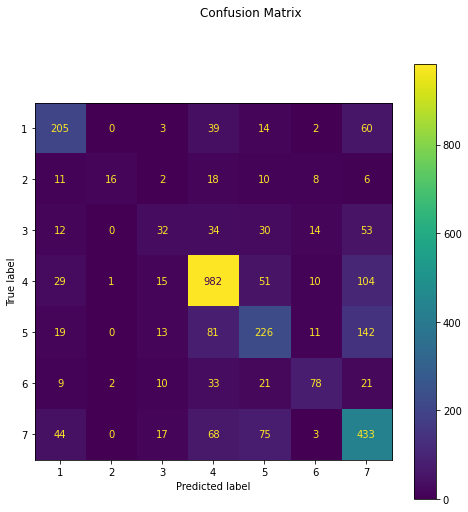

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
#cm = metrics.plot_confusion_matrix(rndSearch, X_train[:sub_size, :], y_test[:sub_size], values_format = 'd', ax=ax)
cm = metrics.plot_confusion_matrix(svg, X_test, y_test, values_format = 'd', ax=ax)
cm.figure_.suptitle("Confusion Matrix")

print(f'Confusion matrix:\n{cm.confusion_matrix}')



In [ ]:
from joblib import dump, load


SAVE_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'svc_hog.joblib')
dump(svg, SAVE_PATH) 
load = load(SAVE_PATH)
